
# Vliv "vzorkovací frekvence" (timeframe) na SMA

Tento notebook ukazuje, jak se mění chování **SMA** při přechodu mezi **denním** a **hodinovým** timeframe, včetně přepočtu ekvivalentního okna (např. denní SMA(20) ≈ hodinová SMA(480)).


In [1]:
# 📦 KROK 1 – Import knihoven
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# 📅 KROK 2 – Simulace hodinových dat (random walk s mírným trendem)
np.random.seed(42)
days = 150                  # ~5 měsíců
hours = days * 24
idx_h = pd.date_range("2024-01-01", periods=hours, freq="h")

returns = np.random.normal(loc=0.0002, scale=0.01, size=hours)  # mírný kladný drift
price = 100 * np.exp(np.cumsum(returns))                        # log-normální cesta

df_h = pd.DataFrame({"Close": price}, index=idx_h)
df_h.head()


,Close
2024-01-01 00:00:00,100.518051
2024-01-01 01:00:00,100.399245
2024-01-01 02:00:00,101.071842
2024-01-01 03:00:00,102.643505
2024-01-01 04:00:00,102.423926


In [19]:

# 🗓️ KROK 3 – Agregace na denní data (vezmeme denní Close = poslední hodinu dne)
df_d = df_h.resample("D").last()
df_d.head()


,Close
2024-01-01,96.983125
2024-01-02,91.489796
2024-01-03,94.091339
2024-01-04,91.583090
2024-01-05,93.145922


In [20]:
N_daily = 20
daily_bar_hours = 24.0     # zjednodušeně pro 24/7 trh
hourly_bar_hours = 1.0

In [21]:

# ⚙️ KROK 5 – Výpočet SMA na denním TF a hodinovém TF (rychlá i ekvivalentní)
df_d["SMA20"] = df_d["Close"].rolling(window=N_daily).mean()

df_h["SMA20_h"] = df_h["Close"].rolling(window=20).mean()

## Graf za 6 měsíců (denní TF)

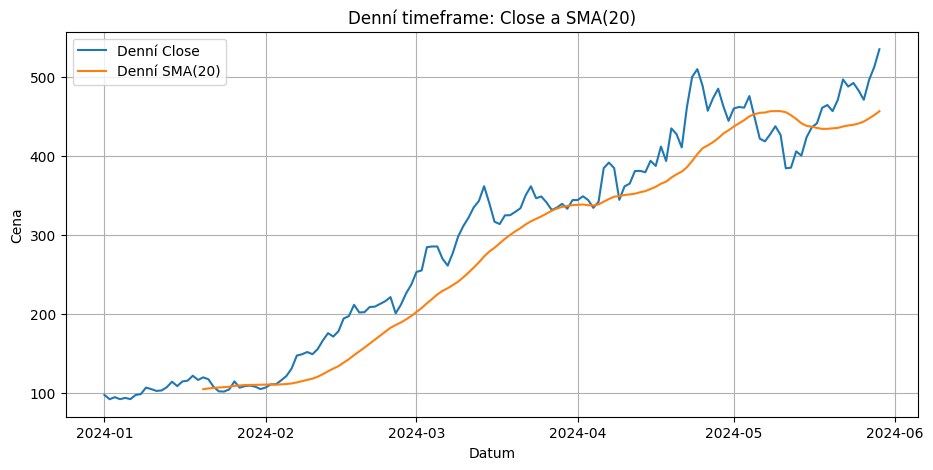

In [22]:

# 📈 KROK 6a – Denní graf: Close + SMA(20)
plt.figure(figsize=(11, 5))
plt.plot(df_d.index, df_d["Close"], label="Denní Close")
plt.plot(df_d.index, df_d["SMA20"], label="Denní SMA(20)")
plt.title("Denní timeframe: Close a SMA(20)")
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.legend()
plt.grid(True)
plt.show()


## Jemnější pohled na graf za 1 měsíc (hodinový TF)
Data jsou jemnější. Díváme se na ně s vyšší "vzorkovací frekvencí" (hodinový TF oproti dennímu TF).

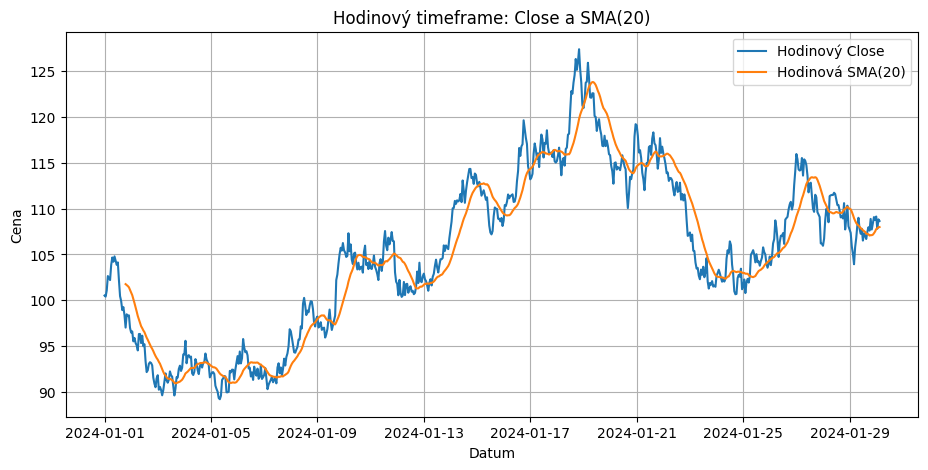

In [16]:
df_h_short = df_h.iloc[0:700]
plt.figure(figsize=(11, 5))
plt.plot(df_h_short.index, df_h_short["Close"], label="Hodinový Close")
plt.plot(df_h_short.index, df_h_short["SMA20_h"], label="Hodinová SMA(20)")
plt.title("Hodinový timeframe: Close a SMA(20)")
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.legend()
plt.grid(True)
plt.show()

## Graf za 6 měsíců (hodinový TF)

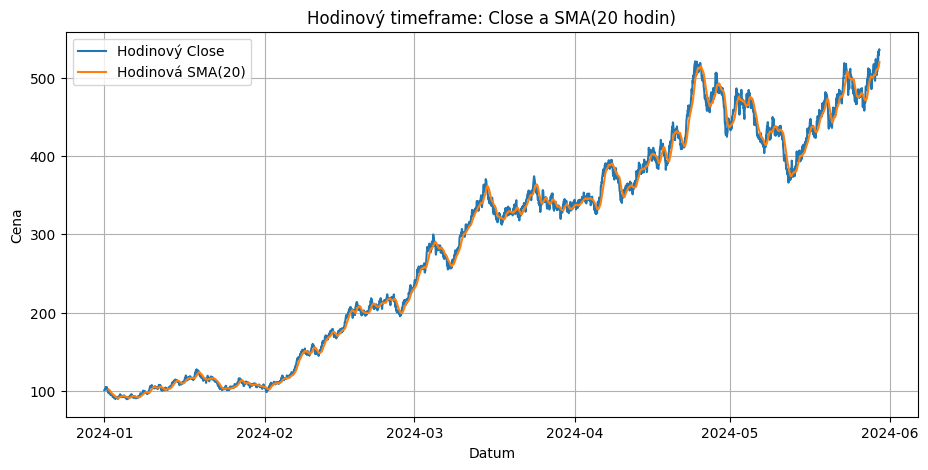

In [17]:

# 📈 KROK 6b – Hodinový graf: Close + SMA(20 hodin)
plt.figure(figsize=(11, 5))
plt.plot(df_h.index, df_h["Close"], label="Hodinový Close")
plt.plot(df_h.index, df_h["SMA20_h"], label="Hodinová SMA(20)")
plt.title("Hodinový timeframe: Close a SMA(20 hodin)")
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.legend()
plt.grid(True)
plt.show()


# Denní timeframe (D1) vs. hodinový timeframe (H1)
Při přechodu z denního na hodinový timeframe se mění "vzorkovací frekvence" dat. To má několik dopadů na chování indikátoru SMA:
1. **Stejná délka periody (SMA(20))** znamená **jinou fyzikální délku času**.
2. **Rychlost reakce** indikátoru se mění.
3. **Citlivost na šum** se mění.
4. **Signály** generované indikátorem se liší.

> [!tip]
> Pro konzistentní analýzu je nutné přepočítat periody indikátorů podle změny timeframe.

## Přepočet periody mezi timeframe
Pro přepočet periody mezi timeframe použijeme následující vzorec:

$$
\text{Nová periody} = \text{Původní periody} \times \frac{\text{Délka původního timeframe}}{\text{Délka nového timeframe}}
$$

### Příklad:
- Denní timeframe (D1) má délku 1 den (24 hodin).
- Hodinový timeframe (H1) má délku 1 hodinu.

Pro přepočet periody SMA(20) z D1 na H1:

$$
\text{Nová periody} = 20 \times \frac{24}{1} = 480
$$

➡️ SMA(20) na denním grafu odpovídá zhruba SMA(480) na hodinovém grafu.

In [8]:
def equivalent_period(n_src: int, src_hours: float, dst_hours: float) -> int:
    """
    Přepočet periody klouzavého průměru mezi timeframy tak,
    aby odpovídala podobnému časovému horizontu.
    n_src: okno na zdrojovém timeframe (počet svíček)
    src_hours: délka jedné svíčky na zdrojovém TF (v hodinách)
    dst_hours: délka jedné svíčky na cílovém TF (v hodinách)
    """
    return int(round(n_src * (src_hours / dst_hours)))


N_equiv_hours = equivalent_period(N_daily, daily_bar_hours, hourly_bar_hours)  # ~480
N_equiv_hours


480

## Graf za 6 měsíců (denní TF)
Upravená délka filtru SMA na hodinovém grafu (SMA(480)) lépe odpovídá dennímu SMA(20), což umožňuje konzistentnější analýzu napříč timeframe.

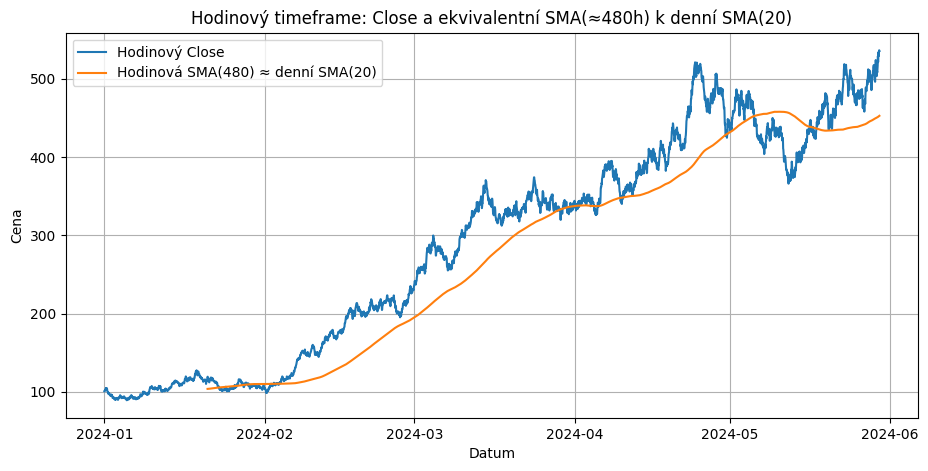

In [9]:

df_h["SMA_equiv"] = df_h["Close"].rolling(window=N_equiv_hours).mean()

# 📈 KROK 6c – Hodinový graf: Close + ekvivalentní SMA(≈480h) k denní SMA(20)
plt.figure(figsize=(11, 5))
plt.plot(df_h.index, df_h["Close"], label="Hodinový Close")
plt.plot(df_h.index, df_h["SMA_equiv"], label=f"Hodinová SMA({N_equiv_hours}) ≈ denní SMA({N_daily})")
plt.title("Hodinový timeframe: Close a ekvivalentní SMA(≈480h) k denní SMA(20)")
plt.xlabel("Datum")
plt.ylabel("Cena")
plt.legend()
plt.grid(True)
plt.show()
